In [ ]:
!pip install numpy
!pip install matplotlib
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from utils import Plant # simulator

Control Systems
---
Cool demos of PID Controllers:
 - [Ball balancing on a stewart platform](https://www.youtube.com/watch?v=j4OmVLc_oDw)
 - [Balancing an inverted pendulum](https://youtu.be/4kIrcELC79o?t=14)

![wikipedia](https://upload.wikimedia.org/wikipedia/commons/3/33/PID_Compensation_Animated.gif)
$$source: wikipedia$$



Control systems are anything used to for a system to reach a **desired state** by controlling the output response. Control systems typically fall into two categories:
 - Open Loop
 - Closed (Feedback) Loop

In **open loop** systems, the output isn't fed back into the controller. Instead, the initial state of the system is given, and the control action is done. In an open loop, the final state is assumed to have reached the **desired state.** 
 - **Example:** A simple dishwasher. The initial state of the dishes are assumed to be dirty, so it will run a wash cycle for 30 minutes. The output state of the dishes are assumed to be clean

![open_loop.jpg](https://www.tutorialspoint.com/control_systems/images/open_loop.jpg)

In a **closed loop** system, the output is fed back into the controller, and the controller constantly updates its control action to reach the desired state. Closed loop controllers are also referred to as feedback controllers.
 - **Example:** An electric kettle with a temperature sensor. You add water and set the desired temperature to 100&deg;C. The kettle will constantly heat the water until it reaches 100&deg;C.
 ![closed_loop.jpg](https://www.tutorialspoint.com/control_systems/images/closed_loop.jpg)
 
Error
---
 Control Systems try to reduce **error** in a system. It's basically a measure of how far away the **current state** is from the **desired state.**
 
$$Error = S_{current} - S_{desired}$$

Bang-Bang Control
---
[wikipedia](https://en.wikipedia.org/wiki/Bang%E2%80%93bang_control)

One of the simplest closed-loop controllers out there is the **bang-bang** controller. It's basically an on/off controller.

The Tea Kettle Company&reg; produces a wide variety of tea kettles. It's first product was the **Tea Kettle of Dubious Quality&trade;**, selling over 2000 units on AliExpress. It uses a simple bang-bang controller to heat the water to 100&deg;C.

Here's how the kettle works:
```
desired_temperature = 100

while (True): #run forever
    error = current_temperature - desired_temperature
    if (error > 0):
        heat()
    else:
        dont()

```

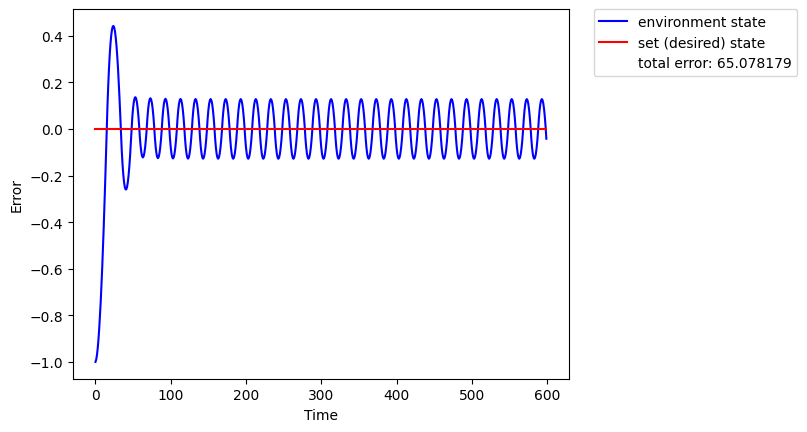

In [3]:
class BangBang(object): #here's our bang-bang controller
    def update(self, error, delta_t):
        
        response = 0
        if error > 0:
            response = 1 # heat()
        elif error < 0:
            response = -1 # dont() too lazy to make a better simulator, so we'll use -1 instead of 0
            
        return response

plant = Plant(BangBang(), set_steady=True)
plant.simulate()
# pretty pictures


Pretty simple. As you can see in the graph above, the error eventually converges near 0. However, it never really reaches the desired state. Instead, the environment state will **oscillate around the desired state**. This can be bad in some applications.

The oscillation happens because the controller has only two options: On or Off. Because of this, the controller itself will continually overshoot, then undershoot the target. 

We'll need a more 'granular' controller to get closer to the desired state.

Proportional Control
---
The proportional controller is also pretty simple. Instead of just turning on and off, it can output a response **between** completely on or completely off.

The **response** of a proportional controller is **proportional** to the error, hence the name. Here's the math behind it.
$$P_{response} = K_{p}*E$$
Where:
 - **Kp** is the proportional gain. You determine this using trial-and-error.
 - **E** is the error
 - **P_response** is the controller response (output)
 
The proportional gain (Kp) is basically a "sensitivity" setting. 

### Challenge 1
1.1) Set Kp to a very low value (0.01) or a high value (0.9). Pay attention to the following:
 - how long it takes to reach the set state
 - oscillation of the environment state

1.2) After receiving raving reviews from bots on Aliexpress, The Tea Kettle Company&reg; is developing a newer product, the **Premium Kettle of Questionable Quality&trade;** The newer kettle will use a proportional controller. Your job is to tune **Kp** such that:
 - total error < 40
 - temperature doesn't visibly overshoot or undershoot more than 3 times total

the output should look like this:
![resources](resources/download.png)

**tl;dr change kp in the cell 2 cells below this one and make it look like the photo above.**

In [5]:
'''
don't change any code in this cell yet
'''
class PController(object):
    def __init__(self, Kp=0.5): # init function. the default Kp value here is 0.5
        self.Kp = Kp

    def update(self, error, delta_t):
        return error*self.Kp

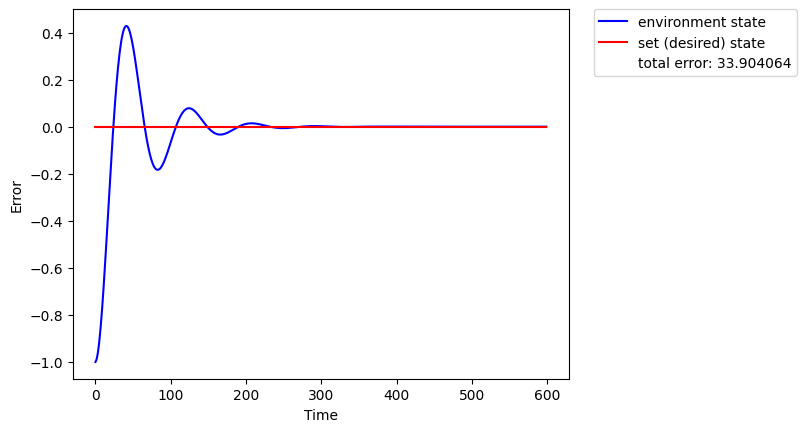

In [40]:
kp = 0.6 # CHALLENGE 1: tune Kp here
controller = PController(kp) # declare and init a PController object. 

plant = Plant(controller, set_steady=True) # declare and init Plant (simulator)
plant.simulate()

If you set Kp to a low value, it'll take a long time to reach the set state. However, if you set Kp too high, it'll oscillate quite a bit. However, you **can** get away with using a high Kp, by adding a derivative component.

PD Controller:
---
The PD Controller, short for Proportional-Derivative Controller, looks at both the **error** and the **derivative**(slope, rate of change) of the error. Determining the derivative is pretty easy:
$$ dE = \frac{\Delta{E}}{\Delta{t}}$$
$$ \Delta{E} = E_{current} - E_{previous} $$
$$ \Delta{t} = t_{current} - t_{previous} $$
 - **E** is the error
 - **t** is time
 
 
The derivative of E is **change in error** / **change in time**. Here's the equation behind the PD Controller  
$$ PD_{response} = K_{p}E + K_{d}dE$$

```
prev_error = 0

while(updating):
    delta_e = error - prev_error
    d_e = delta_e / delta_t
    prev_error = error
```
The derivative of component of the controller will **limit** the effects of the proportional component if the error is changing too quickly. This ensures that the environment state can recover easily if it overshoots or undershoots, reducing the overall oscillation(when tuned properly).

| Pure Proportional Controller | Proportional-Derivative(PD) Controller |
| :---------------------------: | :-------------------------------------: |
| <img src="resources/PD_noD.png"/> | <img src="resources/PD_withD.png"/> |
source: me

Constant Shift
---
There are cases where some obstacle or issue will keep the controller from achieving the set state(faulty sensor, wind, etc.) A pure Proportional or Proportional-Derivative Controller has no way of compensating for this. Try out the code below, and see how the proportional controller reacts to this situation.

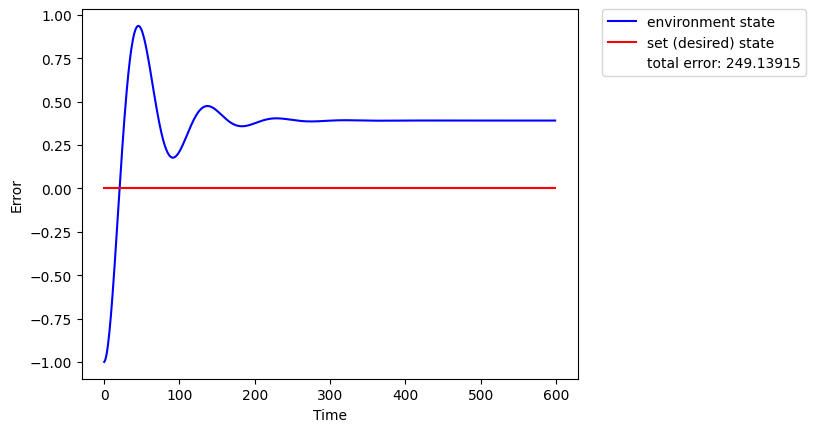

In [41]:
kp = 0.5 # tune Kp here
controller = PController(kp) # declare and init a PController object. 

plant = Plant(controller, set_steady=True, set_shift=True) # declare and init Plant (simulator)
plant.simulate()

As you can see, it will converge on a state, but will never reach the desired state. You can fix this by introducing an additional component&mdash;**the Integral component.**

Proportional-Integral Controller
---
The integral of a function keeps track of the **"history"** of the error; it looks at how it has changed over time. The PI controller is represented as follows:
$$ PI_{response} = K_{p}*E + K_{i}\int_{0}^{t} E*dt $$

Looks pretty scary, but since we're working with discrete measurements, the integral component is basically this:
$$\int_{0}^{t} E(t)dt = (E_{0} + E_{1} + ... + E_{t})*\Delta{t}$$

Its the **sum of errors &ast; change in time**

You don't need to store all the errors, you can just accumulate them each time you make a new measurement.
```
error_accum = 0
while(updating):
    error_accum = error_accum + error
    integral = error_accum * deta_t
```

| PI Controller | PI Controller, poorly tuned |
| :---------------------------: | :-------------------------------------: |
| <img src="resources/PI_withI.png"/> | <img src="resources/PI_highI.png"/> |
source: me

One thing to be careful about the PI controller is that it can make the controller very unstable if poorly tuned. Tune **Ki** sparingly.

Proportional-Integral-Derivative(PID) Controller
---
$$ PID_{response} = K_{p}*E + K_{i}\int_{0}^{t} E*dt + K_{d}dE$$
Combine all three components, and you'll have yourself a PID controller! The PID controller is fairly robust, and is suitable for almost any application, given proper tuning. To recap:
 - **Proportional** component reduces current error
 - **Integral** component reduces constant shift/offset
 - **Derivative** component reduces oscillation

Each component has a gain, **K**. You can tune these gains through trial-and-error. It's recommended that you tune the gains in the following order (P-D-I) :
1. **Kp:** tune until it quickly reaches the set state
2. **Kd:** tune until oscillations are reasonably reduced
3. **Ki:** tune only if constant shift is present

Try to keep the gains as low as possible.
![wikipedia](https://upload.wikimedia.org/wikipedia/commons/3/33/PID_Compensation_Animated.gif)
source: wikipedia

Challenge 2
---
The Tea Kettle Company &reg; is developing their latest and greatest product, the **iKettle&trade;**, a smart kettle that will revolutionize the tea space. They've hired you to develop a controller that can heat water to temperatures that the user sets. However, due to the dubious product quality of their products, the tea kettle can't always heat the water properly. **Write a PID controller** that can both account for the constant offset of the water temperature, and reduce temperature oscillations, as to not overheat the crappy heating element. The output should look like this:
![output](resources/PID_tuned.png)

**tl;dr write & tune a PID controller. skeleton code provided**

In [120]:
class PIDController(object):
    prev_error = 0.0
    accumulated_error = 0.0
    def __init__(self, Kp=0.0, Ki=0.0, Kd=0.0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        
    def update(self, error, delta_t):
        p = self.Kp * error
        
        '''
        CHALLENGE 2: YOUR CODE HERE
        '''
        self.accumulated_error += error

        response = p + self.Ki * self.accumulated_error * delta_t + self.Kd * (error - self.prev_error) / delta_t
        self.prev_error =  error
        return response

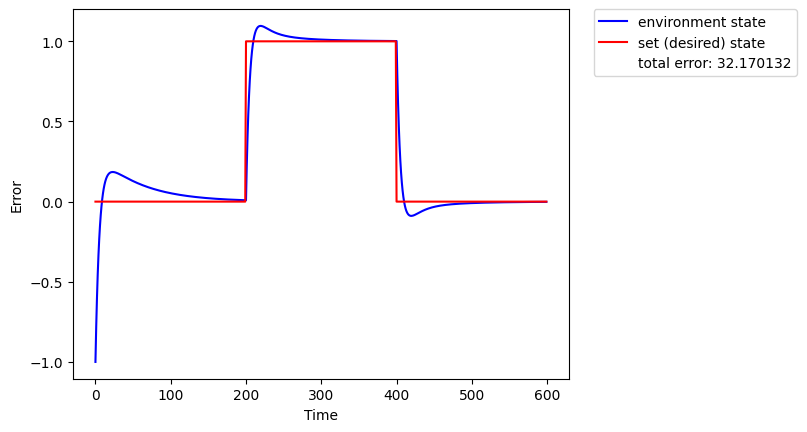

In [147]:
Kp = 1.5 #tune me!
Ki = 0.2 #tune me!
Kd = 2 #tune me!
controller = PIDController(Kp, Ki, Kd)

plant = Plant(controller, set_shift=True)
plant.simulate()

Bonus
---
Try the controller in a noisy system!

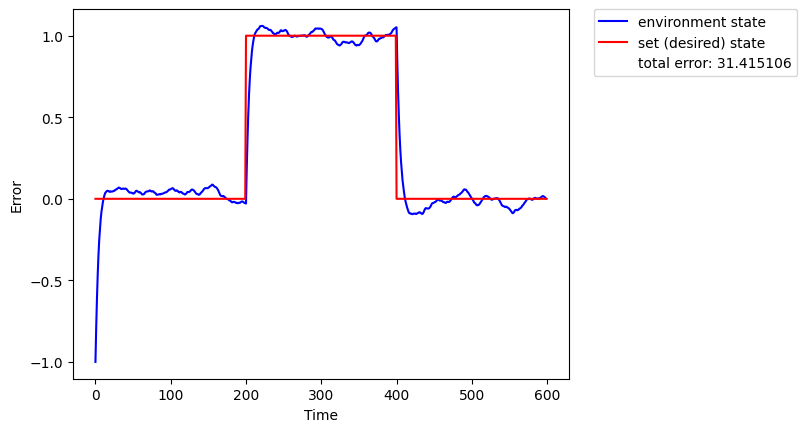

In [148]:
plant = Plant(controller, set_shift=True, noise=True)
plant.simulate()